# Acknowledgements

In [1]:
# Original idea, paper, and DeepXDE library from Lu Lu et al.
# https://arxiv.org/abs/1907.04502

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import deepxde as dde
from deepxde.backend import tf

Using backend: paddle
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, jax.
paddle supports more examples now and is recommended.


# Custom Functions and Equation Setup

In [3]:
def pde(x, y):
    """
    Defines the discretized solution to the 1D Burgers" Equation.

    IC u(x, 0) = - sin(\pi x), u( - 1, t) = u(1, t) = 0.
    """
    dy_x = dde.grad.jacobian(y, x, i=0, j=0) # solves first partial w.r.t x
    dy_t = dde.grad.jacobian(y, x, i=0, j=1) # solves first partial w.r.t y
    dy_xx = dde.grad.hessian(y, x, i=0, j=0) # solves second partial deritive
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

### Modeling IC/BC

In [4]:
# modeling constraints to imitate the Burgers" equations" limitations in physical context
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

# Exact Solution / Model Data

In [5]:
def gen_testdata():
    """ 
    Extracts the exact solution for the Burgers" equation.
    """
    df = np.load("Burgers.npz")
    t, x, exact = df["t"], df["x"], df["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

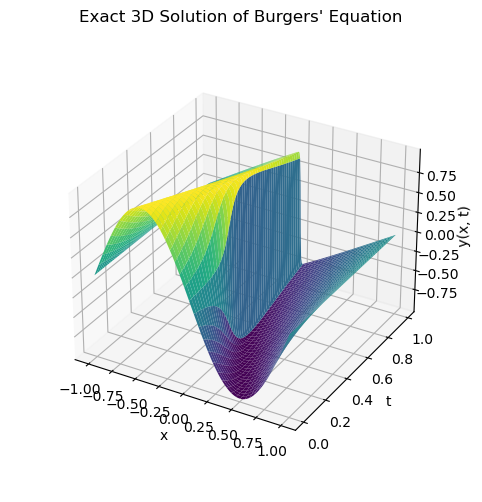

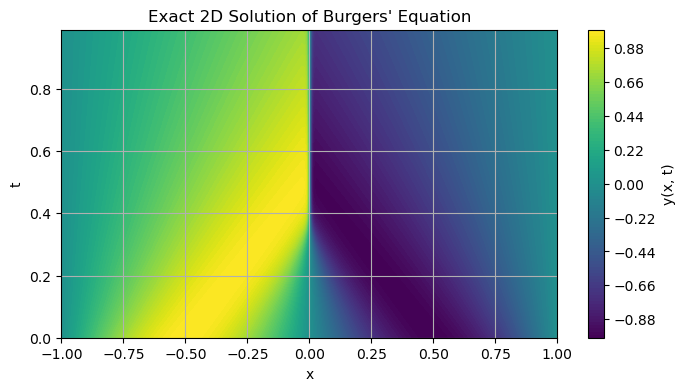

In [6]:
# Generate test data
X, y = gen_testdata()

# Reshape data for plotting
xx = X[:, 0].reshape(len(np.unique(X[:, 1])), -1)
tt = X[:, 1].reshape(len(np.unique(X[:, 1])), -1)
yy = y.reshape(xx.shape)

# 3D Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(xx, tt, yy, cmap="viridis")
plt.title("Exact 3D Solution of Burgers' Equation")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("y(x, t)")
ax.set_box_aspect(None, zoom=0.85)
filename = "Burgers-3D"
plt.savefig(f"../images/{filename}.png")
plt.show()

# 2D Plot
plt.figure(figsize=(8, 4))
contour = plt.contourf(xx, tt, yy, cmap="viridis", levels=100)
plt.colorbar(contour, label="y(x, t)")
plt.title("Exact 2D Solution of Burgers' Equation")
plt.xlabel("x")
plt.ylabel("t")
plt.grid(True)
filename = "Burgers-2D"
plt.savefig(f"../images/{filename}.png")
plt.show()

In [7]:
# function to extract the error from the model history
def export_error(input_file, output_file):
    """ 
    Extracts the exact function from the Burgers.npz dataset
    """
    steps = []
    loss_train = []
    loss_test = []
    with open(input_file, "r") as file:
        next(file)  # Skip header line
        for line in file:
            values = line.split()
            steps.append(float(values[0]))  # First value is the step
            loss_train.append(float(values[1]))  # Second value is loss_train
            loss_test.append(float(values[2]))  # Third value is loss_test

    # Combine the arrays into a pandas DataFrame
    df = pd.DataFrame({"Step": np.array(steps),
                       "Training Loss": np.array(loss_train),
                       "Test Loss": np.array(loss_test)})

    # Specify the file path for the CSV
    filepath = f"error/{output_file}.csv"
    df.to_csv(filepath, index=False)

In [8]:
# error plot function
def plot_error(title, df, output_file):
    """ 
    Plots the error from the given df.
    """
    plt.figure(figsize=(8,4))
    plt.title(f"{title} Error")
    plt.xlabel("Training Step")
    plt.ylabel("Error")
    plt.yscale("log")

    plt.plot(df["Step"], df["Training Loss"], linewidth=2, alpha=0.8, label="Training Error")
    plt.plot(df["Step"], df["Test Loss"], color="tab:orange", alpha=0.4, label="Test Error", linestyle="--")
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")

    filepath = f"../images/{output_file}.png"
    plt.savefig(filepath, bbox_inches="tight", pad_inches=0.2, dpi=100, facecolor="white")
    plt.show()

# Training and Visualizing Model Performance

In [9]:
# # generate starting X
np.random.seed(123)
X = geomtime.random_points(100000)

### RAR w/ PINNs

In [10]:
# sets up PINN for training
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2500, num_boundary=100, num_initial=100)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
pinn_rar = dde.Model(data, net)

In [11]:
# initial model training & error collection
pinn_rar.compile("adam", lr=1e-3)
losshistory, train_state = pinn_rar.train(iterations=10000)
pinn_rar.compile("L-BFGS-B")
losshistory, train_state = pinn_rar.train()

# RAR process
err = 1
while err > 0.005: 
    # error collect
    f = pinn_rar.predict(X, operator=pde) # pde is being incorporated in the prediction here, making it a PINN
    err_eq = np.absolute(f)
    err = np.mean(err_eq)
    print("Mean residual: %.3e" % (err))

    # find the point with the highest error and add to anchors
    x_id = np.argmax(err_eq) 
    print("Adding new point:", X[x_id], "\n")
    data.add_anchors(X[x_id])

    # early stopping condition
    early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-4, patience=2000) 

    # update the model
    pinn_rar.compile("adam", lr=1e-3)
    pinn_rar.train(iterations=10000, disregard_previous_best=True, callbacks=[early_stopping])
    pinn_rar.compile("L-BFGS")
    losshistory, train_state = pinn_rar.train()

Compiling model...
'compile' took 0.000175 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.80e-01, 6.96e-02, 6.10e-01]    [1.80e-01, 6.96e-02, 6.10e-01]    []  
1000      [4.75e-02, 1.04e-03, 6.09e-02]    [4.75e-02, 1.04e-03, 6.09e-02]    []  
2000      [3.30e-02, 7.39e-05, 4.86e-02]    [3.30e-02, 7.39e-05, 4.86e-02]    []  
3000      [2.49e-02, 4.46e-05, 3.63e-02]    [2.49e-02, 4.46e-05, 3.63e-02]    []  
4000      [8.42e-03, 4.08e-05, 7.44e-03]    [8.42e-03, 4.08e-05, 7.44e-03]    []  
5000      [4.30e-03, 1.27e-05, 4.16e-03]    [4.30e-03, 1.27e-05, 4.16e-03]    []  
6000      [3.25e-03, 7.59e-06, 3.25e-03]    [3.25e-03, 7.59e-06, 3.25e-03]    []  
7000      [2.58e-03, 7.98e-06, 2.38e-03]    [2.58e-03, 7.98e-06, 2.38e-03]    []  
8000      [2.27e-03, 8.99e-06, 1.98e-03]    [2.27e-03, 8.99e-06, 1.98e-03]    []  
9000      [1.91e-03, 7.02e-06, 1.63e-03]    [1.91e-03, 7.02e-06, 1.63e-03]    []  
10000     [1.65

Saving loss history to d:\GitHub\pinns-teaching-uis\burgers-example\loss.dat ...
Saving training data to d:\GitHub\pinns-teaching-uis\burgers-example\train.dat ...
Saving test data to d:\GitHub\pinns-teaching-uis\burgers-example\test.dat ...


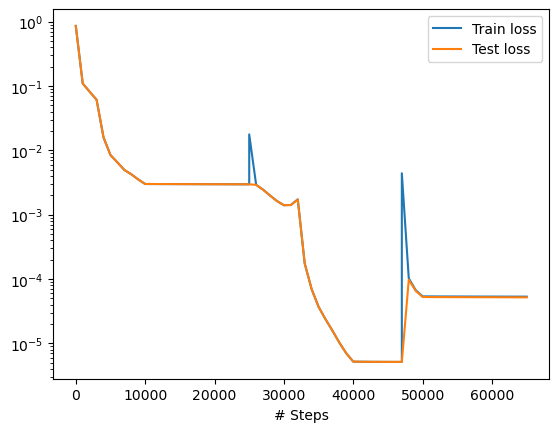

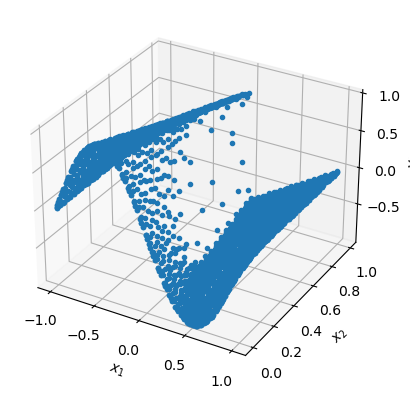

In [12]:
# Save the results & using DeepXDE built-in graphing for model prediction
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
input_file = "loss.dat"
output_file = "pinns_rar"
export_error(input_file, output_file)

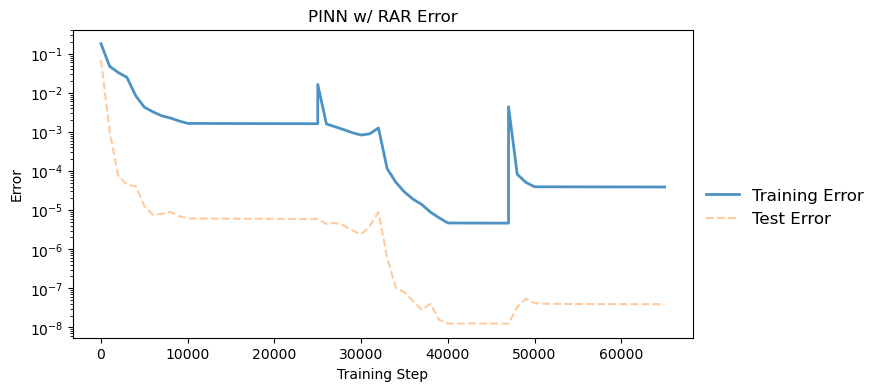

In [13]:
# Plot the error
title = "PINN w/ RAR"
df = pd.read_csv(f"error/{output_file}.csv")
output_file = "Burgers-PINN-RAR"
plot_error(title, df, output_file)

### PINNs w/o RAR

In [14]:
# sets up PINN w/o RAR for training
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
pinn = dde.Model(data, net)

In [15]:
# train the model
pinn.compile("adam", lr=1e-3)
pinn.train(iterations=15000)
pinn.compile("L-BFGS")
losshistory, train_state = pinn.train()

Compiling model...
'compile' took 0.000263 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.81e-03, 5.95e-03, 5.47e-01]    [9.81e-03, 5.95e-03, 5.47e-01]    []  
1000      [4.21e-02, 7.09e-04, 5.38e-02]    [4.21e-02, 7.09e-04, 5.38e-02]    []  
2000      [2.84e-02, 7.38e-05, 3.90e-02]    [2.84e-02, 7.38e-05, 3.90e-02]    []  
3000      [2.14e-02, 1.42e-04, 2.19e-02]    [2.14e-02, 1.42e-04, 2.19e-02]    []  
4000      [1.11e-02, 3.30e-05, 8.95e-03]    [1.11e-02, 3.30e-05, 8.95e-03]    []  
5000      [8.54e-03, 1.06e-05, 6.36e-03]    [8.54e-03, 1.06e-05, 6.36e-03]    []  
6000      [1.07e-02, 2.52e-05, 5.65e-03]    [1.07e-02, 2.52e-05, 5.65e-03]    []  
7000      [6.26e-03, 5.47e-06, 4.74e-03]    [6.26e-03, 5.47e-06, 4.74e-03]    []  
8000      [5.33e-03, 5.16e-06, 4.37e-03]    [5.33e-03, 5.16e-06, 4.37e-03]    []  
9000      [4.71e-03, 4.61e-06, 4.21e-03]    [4.71e-03, 4.61e-06, 4.21e-03]    []  
10000     [4.30

Saving loss history to d:\GitHub\pinns-teaching-uis\burgers-example\loss.dat ...
Saving training data to d:\GitHub\pinns-teaching-uis\burgers-example\train.dat ...
Saving test data to d:\GitHub\pinns-teaching-uis\burgers-example\test.dat ...


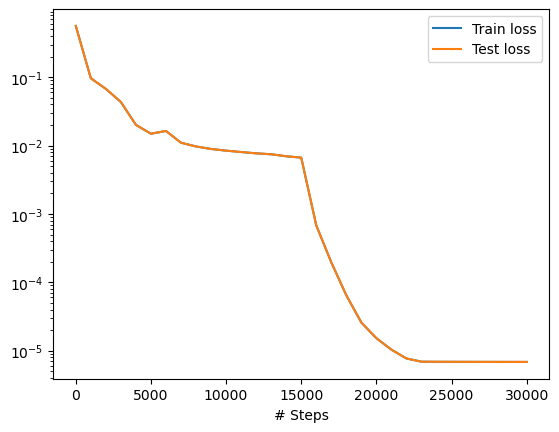

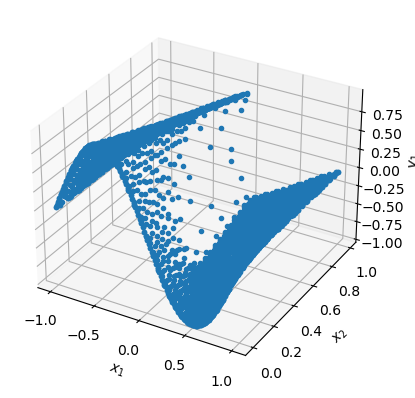

In [16]:
# Save the results & using DeepXDE built-in graphing for model prediction
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
input_file = "loss.dat"
output_file = "pinns"
export_error(input_file, output_file)

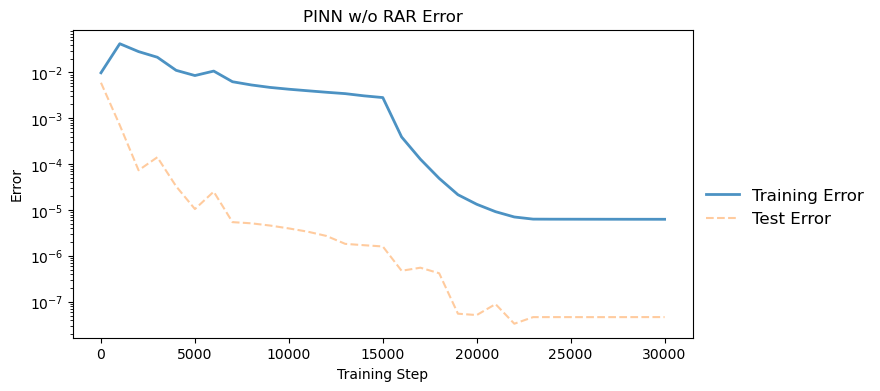

In [17]:
# Plot the data
title = "PINN w/o RAR"
df = pd.read_csv(f"error/{output_file}.csv")
output_file = "Burgers-PINN"
plot_error(title, df, output_file)

### Comparison

In [18]:
df_pinn_rar = pd.read_csv(f"error/pinns_rar.csv")
df_pinn = pd.read_csv(f"error/pinns.csv")
df_pinn["Step"].tail(1).item()

30000.0

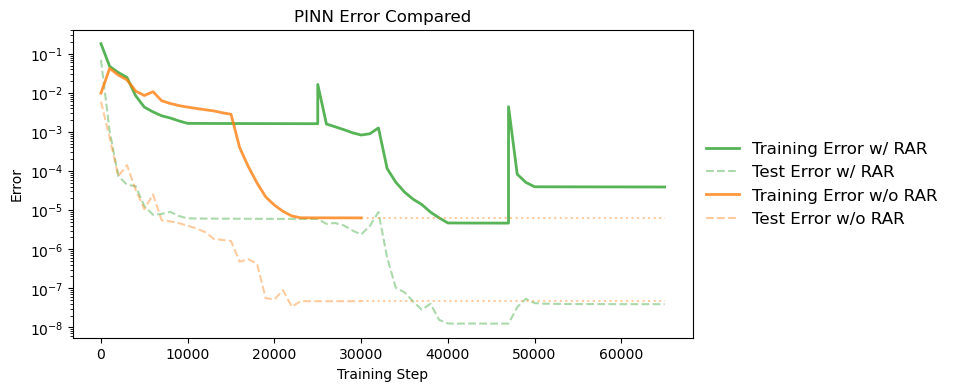

In [19]:
df_pinn_rar = pd.read_csv(f"error/pinns_rar.csv")
df_pinn = pd.read_csv(f"error/pinns.csv")

plt.figure(figsize=(8, 4))
plt.title(f"PINN Error Compared")
plt.xlabel("Training Step")
plt.ylabel("Error")
plt.yscale("log")

plt.plot(df_pinn_rar["Step"], df_pinn_rar["Training Loss"], color="tab:green", linewidth=2, alpha=0.8, label="Training Error w/ RAR")
plt.plot(df_pinn_rar["Step"], df_pinn_rar["Test Loss"], color="tab:green", alpha=0.4, label="Test Error w/ RAR", linestyle="--")
plt.plot(df_pinn["Step"], df_pinn["Training Loss"], color="tab:orange", linewidth=2, alpha=0.8, label="Training Error w/o RAR")
plt.plot(df_pinn["Step"], df_pinn["Test Loss"], color="tab:orange", alpha=0.4, label="Test Error w/o RAR", linestyle="--")
plt.hlines(df_pinn["Test Loss"].tail(1).item(), df_pinn["Step"].tail(1).item(), df_pinn_rar["Step"].tail(1).item(), color="tab:orange", alpha=0.4, linestyle="dotted")
plt.hlines(df_pinn["Training Loss"].tail(1).item(), df_pinn["Step"].tail(1).item(), df_pinn_rar["Step"].tail(1).item(), color="tab:orange", alpha=0.4, linestyle="dotted")

l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
plt.setp(l.get_texts(), color="k")

filename = "Burgers-Compare"
filepath = f"../images/{filename}.png"
plt.savefig(filepath, bbox_inches="tight", pad_inches=0.2, dpi=100, facecolor="white")
plt.show()